<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

##  HOW TO obtain archival ESO data given RA and Dec

The [ESO archive](http://archive.eso.org/cms.html) currently (June 2020) contains more than [1.7 million spectra](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=SPECTRUM&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22SPECTRUM%22%3atrue%7d&at=119.452774,-60.30286&sr=i), more than [650,000 images](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=IMAGE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22IMAGE%22%3atrue%7d&at=160.465004,19.501825&sr=i), and more than [240,000 cubes](https://archive.eso.org/scienceportal/home?data_release_date=*:2020-06-24&dp_type=CUBE&sort=-obs_date&s=P%2fDSS2%2fcolor&f=177.115919&fc=-1,-1&cs=J2000&av=true&ac=false&c=9,10,11,12,13,14,15,16,17,18,19,20&ta=RES&dts=true&sdtm=%7b%22CUBE%22%3atrue%7d&at=239.591811,-14.166308&sr=i) that are reduced or fully calibrated.

There are three main ways to access the vaste amount of information present in the [ESO archive](http://archive.eso.org/cms.html):

* the [Raw Data query form](http://archive.eso.org/eso/eso_archive_main.html)
* the [Science Portal](http://archive.eso.org/scienceportal/home) to browse and access the processed data
* the [Programmatic and Tools access](http://archive.eso.org/programmatic/) which permits direct database access to both raw and processed data, and to the ambient condition measurements

In addition, the <code>archive_observations</code> module part of the (unofficial) [ESOAsg](https://github.com/EmAstro/ESOAsg) package provides simple wrappers to efficiently embed the access to the [ESO archive](http://archive.eso.org/cms.html) into <code>python</code> routines.

With this example, we show how to obtain all science spectra associated to an object for which the location in the sky is known. 

In case you use data from the ESO Archive for your research, please consider the [ESO acknowledgement policies](http://archive.eso.org/cms/eso-data-access-policy.html#acknowledgement).

**Usage**: You can access this file as an interactive jupyter notebook, which you can download and run on your machine [(instructions)](https://jupyter.org/install). To interact with the jupyter notebook (if you have download it): move up and down the various cells using the arrow keys, execute the code by pressing CTRL+ENTER; you can also modify the code and execute it at will.

**Version**: Please note that this notebook uses Python version 3.9.13 and Jupyter Notebook version 6.4.10. Compatibility with other versions cannot be guaranteed.

**Authors**: Emanuele Paolo Farina & Ashley Thomas Barnes

**Table of Content**

0. [**Imports and instantiate the TAP service**](#imports)

---
## <a id='imports'>0. Imports - inc. ESOAsg package</a>

In [1]:
from ESOAsg import archive_observations # ESO Archive Observations

from astropy.coordinates import SkyCoord # Astropy coordinates
from astropy.io import fits # Astropy FITS files
import astropy.constants as const # Astropy constants
import astropy.units as u # Astropy units
import matplotlib.pyplot as plt # Matplotlib
import numpy as np # Numpy
from PyAstronomy import pyasl # PyAstronomy - used for Baricentric correction if not in header

# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


---
## <a id='RA/Dec'>1. Get RA and Dec of one target (or more) </a>

To begin, you need to choose the targets you would like to explore and get their coordinates. These need to be an [astropy.coordinates](https://docs.astropy.org/en/stable/coordinates/) `SkyCoord` object. A `SkyCoord` object can easily be created by using:
```python
from astropy import units as u
from astropy.coordinates import SkyCoord
coordinates = SkyCoord(ra=10.625*u.degree, dec=41.2*u.degree, frame='icrs')
```
For this example, we consider a couple of standard stars observed as part of the [`MUSE library of stellar spectra`](https://www.eso.org/sci/publications/announcements/sciann17288.html) project ([Ivanov et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...629A.100I/abstract)): 
* [HD 057060](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+057060&submit=SIMBAD+search)
* [HD 172230](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+172230&submit=SIMBAD+search).

The coordinates of these two well known stars can be simply retrieved from their name using `Sesame` (and we are storing them in the list: `star_positions`):

In [2]:
star_names = ['HD 057060', 'HD 172230']
star_positions = []
for star_name in star_names:
    star_positions.append(SkyCoord.from_name(star_name))
    print('{}: {}'.format(star_name, SkyCoord.from_name(star_name).to_string('hmsdms')))

HD 057060: 07h18m40.37893537s -24d33m31.31824853s
HD 172230: 18h38m54.9539035s +06d16m14.8140394s


---
## <a id='RA/Dec'>2. Query the archive </a>

The function <code>archive_observations.query_from_radec</code> allows to explore the processed data (also known as ADPs) within a certain radius in arcseconds (e.g., radius=5.) from a given position (e.g., for HD 057060: RA=109.66824871, Dec=-24.55869773). 

It is also possible to limit the search to specific instruments (e.g., 'MUSE', 'XSHOOTER', 'UVES') or specific data types (e.g., 'spectrum').

In practice, this corresponds to run the following [TAP query](http://archive.eso.org/programmatic/#TAP?f=text&m=200&q=SELECT%0A%20%20%20%20target_name%2C%20dp_id%2C%20s_ra%2C%20s_dec%2C%20t_exptime%2C%20em_min%2C%20em_max%2C%20%0A%20%20%20%20dataproduct_type%2C%20instrument_name%2C%20obstech%2C%20abmaglim%2C%0A%20%20%20%20proposal_id%2C%20obs_collection%0AFROM%0A%20%20%20%20ivoa.ObsCore%0AWHERE%0A%20%20%20%20INTERSECTS&#40;s_region%2CCIRCLE&#40;'ICRS'%2C109.66824871%2C-24.55869773%2C5.0%2F3600.&#41;&#41;%3D1%0AAND%0A%20%20%20%20dataproduct_type%3D'spectrum'&):

```SQL
SELECT
    target_name, dp_id, s_ra, s_dec, t_exptime, em_min, em_max, 
    dataproduct_type, instrument_name, obstech, abmaglim,
    proposal_id, obs_collection
FROM
    ivoa.ObsCore
WHERE
    INTERSECTS(s_region,CIRCLE('ICRS',109.66824871,-24.55869773,5.0/3600.))=1
AND
    dataproduct_type='spectrum'
AND 
    em_min>4.0e-7 
AND 
    em_max<1.2e-6 
```

In this example, we are interested only to the optical data, so we limit the result of the queries to:

`em_min>4.0e-7 & em_max<1.2e-6`

where the limits in wavelength are expressed in meters. In other words, we are limiting the wavelength coverage to:

$4000 \mathring A < \lambda < 12000 \mathring A$

In [56]:
result_from_queries = archive_observations.query_from_radec(star_positions, radius=5, data_types= 'spectrum', verbose=False, 
                                                            em_min=4.0e-7, em_max=1.2e-6)

[WORKING] :: Running query 1 to the ESO archive (out of 2 total)
[INFO]    :: A total of 9 entries has been retrieved
[WORKING] :: Running query 2 to the ESO archive (out of 2 total)
[INFO]    :: A total of 6 entries has been retrieved


The results are stored in a list of astropy tables (one table per position). 

For HD 057060:

In [4]:
result_from_queries[0].show_in_notebook(show_row_index=False)

target_name,dp_id,s_ra,s_dec,t_exptime,em_min,em_max,dataproduct_type,instrument_name,obstech,abmaglim,proposal_id,obs_collection
,,deg,deg,s,m,m,,,,mag,,
UW CMa,ADP.2024-11-11T14:37:21.583,109.668353,-24.55882,599.998,4.58307e-07,6.68642e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
HD_57060,ADP.2020-07-10T21:41:17.392,109.668059,-24.559,23.999,6.65032e-07,1.042598e-06,spectrum,UVES,ECHELLE,--,076.B-0055(A),UVES
2MASS-J07184037-2433312,ADP.2017-06-02T19:41:04.876,109.668427,-24.55842,0.4,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,OFFSET",--,084.B-0869(B),XSHOOTER
UW CMa,ADP.2024-11-11T14:32:23.771,109.668158,-24.55871,299.999,4.58307e-07,6.68644e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
HD057060,ADP.2020-07-28T07:32:26.167,109.66825,-24.558697,0.4,5.339e-07,1.020441e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,OFFSET",--,084.B-0869(B),XSL
UW CMa,ADP.2024-11-11T14:31:22.374,109.668245,-24.55866,299.999,4.58308e-07,6.686430000000001e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES
HD 057060,ADP.2020-02-26T15:36:25.254,109.668254,-24.558703,0.9,4.74969e-07,9.34969e-07,spectrum,MUSE,IFU,--,099.D-0623(A),MUSE-STD
HD_57060,ADP.2020-07-10T21:41:17.417,109.668097,-24.55898,23.999,4.72685e-07,6.83502e-07,spectrum,UVES,ECHELLE,--,076.B-0055(A),UVES
UW CMa,ADP.2024-11-11T14:29:38.651,109.66832,-24.55885,299.999,4.58307e-07,6.686430000000001e-07,spectrum,UVES,ECHELLE,--,114.27D9.001,UVES


For HD 172230:

In [5]:
result_from_queries[1].show_in_notebook(show_row_index=False)

target_name,dp_id,s_ra,s_dec,t_exptime,em_min,em_max,dataproduct_type,instrument_name,obstech,abmaglim,proposal_id,obs_collection
,,deg,deg,s,m,m,,,,mag,,
HD 172230,ADP.2020-02-26T15:36:25.276,279.728983,6.270793,24.0,4.75021e-07,9.35146e-07,spectrum,MUSE,IFU,--,099.D-0623(A),MUSE-STD
HD_172230,ADP.2021-09-16T14:46:40.592,279.728906,6.27063,99.998,6.650249999999999e-07,1.042609e-06,spectrum,UVES,ECHELLE,--,079.D-0567(A),UVES
HD172230,ADP.2020-07-28T07:32:26.286,279.728958,6.270786,2.2,5.33736e-07,1.0201269999999999e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSL
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:53.210,279.729289,6.27105,0.1,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,STARE",--,085.B-0751(A),XSHOOTER
2MASS-J18385494+0616147,ADP.2014-05-15T16:36:52.997,279.729582,6.27016,2.2,5.336599999999999e-07,1.02e-06,spectrum,XSHOOTER,"ECHELLE,SLIT,NODDING",--,085.B-0751(A),XSHOOTER
HD_172230,ADP.2021-09-16T14:46:40.723,279.728885,6.27061,119.996,4.72686e-07,6.83508e-07,spectrum,UVES,ECHELLE,--,079.D-0567(A),UVES


#### <a id='RA/Dec Bonus'> Bonus: the Archive Science Portal (ASP) </a>

As a complementary approach, you can also explore the [Archive Science Portal](http://archive.eso.org/scienceportal/home) at specific locations. This could be done by running:

```python
from ESOAsg import archive_science_portal
archive_science_portal.query_from_radec(position_list, radius=5.)
```

This should open different [Archive Science Portal](http://archive.eso.org/scienceportal/home) pages in your broswer (one per positions) pointing to the different regions of the sky you are quering.

In [6]:
# from ESOAsg import archive_science_portal
# archive_science_portal.query_from_radec(star_positions, radius=5., open_link=True, 
#                                         data_types='spectrum', instruments='MUSE')

---
## <a id='download'>3. Download the Archive Data Products </a>

Now it is time to download the ADPs that you are interested in. 

This is done by passing the `dp_id` column to `archive_observations.download`.

In [ ]:
for result_table in result_from_queries:
    archive_observations.download(result_table['dp_id'], output_dir='./data/')

[INFO]    :: Your disk has:
[INFO]    :: Total: 926.35 GB, Used: 670.97 GB, Free: 255.38 GB
[WORKING] :: Retrieving file ADP.2024-11-11T14:37:21.583.fits
[INFO]    :: No file downloaded - Response code: 401
[WORKING] :: Retrieving file ADP.2024-11-11T14:37:21.583.fits
[WORKING] :: Retrieving file ADP.2020-07-10T21:41:17.392.fits
[INFO]    :: File ADP.2020-07-10T21:41:17.392.fits downloaded
[WORKING] :: Retrieving file ADP.2020-07-10T21:41:17.392.fits
[WORKING] :: Retrieving file ADP.2017-06-02T19:41:04.876.fits
[INFO]    :: File ADP.2017-06-02T19:41:04.876.fits downloaded
[WORKING] :: Retrieving file ADP.2017-06-02T19:41:04.876.fits
[WORKING] :: Retrieving file ADP.2024-11-11T14:32:23.771.fits
[INFO]    :: No file downloaded - Response code: 401
[WORKING] :: Retrieving file ADP.2024-11-11T14:32:23.771.fits
[WORKING] :: Retrieving file ADP.2020-07-28T07:32:26.167.fits
[INFO]    :: File ADP.2020-07-28T07:32:26.167.fits downloaded
[WORKING] :: Retrieving file ADP.2020-07-28T07:32:26.167.f

---
## <a id='explore_data'>4. Explore the data... </a>

Now the `MUSE`, `XSHOOTER`, and `UVES` optical spectra of `HD 057060` and `HD 172230` are on disk. You can explore them with your favourite tools. 

### <a id='HD 057060'> HD 057060 </a>

Normalize spectra from different instrument at $8000 \mathring A$ and show the different shapes:

In [8]:
hdu_muse =      fits.open('./data/ADP.2020-02-26T15:36:25.254.fits')
hdu_xshooter1 = fits.open('./data/ADP.2017-06-02T19:41:04.876.fits') # Older version of the dataset - Interal data product (IDP) 
hdu_xshooter2 = fits.open('./data/ADP.2020-07-28T07:32:26.167.fits') # Newest version of the dataset - External data product (EDP)
hdu_uves1 =     fits.open('./data/ADP.2020-07-10T21:41:17.392.fits')
hdu_uves2 =     fits.open('./data/ADP.2020-07-10T21:41:17.417.fits')

In [9]:
def extract_spectrum(hdu, instrument, verbose=False, check_bary=False):
    
    hdu_0 = hdu[0]
    hdu_1 = hdu[1]

    print(f'SPECSYS for {instrument}: {hdu_0.header["SPECSYS"]}')

    # Shifting to Ang.
    if hdu_1.header['TUNIT1'] == 'nm':
        wave_corr = 10. # Get to Ang.
    else:
        wave_corr = 1. # Already in Ang.

    # Perform barycentric correction
    if 'HIERARCH ESO QC VRAD BARYCOR' in hdu_0.header: 
        barycorr = hdu_0.header['HIERARCH ESO QC VRAD BARYCOR']
        wave_corr *= (1. + (barycorr/const.c.to('km/s').value))
        print(f'Barycentric correction for {instrument}: {barycorr}')
        
    elif 'HELICORR' in hdu_0.header:
        barycorr = hdu_0.header['HELICORR']
        wave_corr *= (1. + (barycorr/const.c.to('km/s').value))
        print(f'Barycentric correction for {instrument}: {barycorr}')

    no_bary = (hdu_0.header["SPECSYS"] == 'TOPOCENT') and ('HIERARCH ESO QC VRAD BARYCOR' not in hdu_0.header)
    if no_bary or check_bary: 
    
        ra = hdu[0].header['RA']
        dec = hdu[0].header['DEC']
        mjd = hdu[0].header['MJD-OBS'] # Modified JD for the observation
        jd = mjd + 2400000.5 # JD for the observation
        heliocorr, barycorr = pyasl.baryCorr(jd, ra, dec)
        if no_bary:
            wave_corr *= (1. + (barycorr/const.c.to('km/s').value))
        print(f'Barycentric correction for {instrument}: {barycorr} (using PyAstronomy)')
        
    if hdu_0.header['SPECSYS'] == 'SOURCE':
        sourcecorr = hdu_0.header['REST_VAL']
        wave_corr *= (1. + (sourcecorr/const.c.to('km/s').value))
        print(f'Source correction for {instrument}: {sourcecorr}')

    if instrument == 'MUSE':
        # No corrections needed for the MUSE spectrum - 'erg cm**(-2) s**(-1) angstrom**(-1)'
        flux_corr = 1.
    
    elif instrument == 'XSHOOTER':
        # No corrections needed for the MUSE spectrum - 'erg cm**(-2) s**(-1) angstrom**(-1)'
        flux_corr = 1.
    
    elif instrument == 'UVES':
        # Correcting the UVES spectrum by factor 1e-16 - 'erg s**(-1) cm**(-2) angstrom**(-1)'
        flux_corr = 1e-16
    
    spec_wave = hdu_1.data['WAVE'].squeeze() * wave_corr
    spec_flux = hdu_1.data['FLUX'].squeeze() * flux_corr
    spec_err = hdu_1.data['ERR'].squeeze() * flux_corr    

    spec_flux[spec_flux==0] = np.nan
    spec_err[spec_err==0] = np.nan
    
    if verbose:
        print('Content of the {} spectrum: \n {} \n'.format(instrument, hdu_1.columns))
        
    return spec_wave, spec_flux, spec_err    

spec_muse_wave, spec_muse_flux, spec_muse_fluxerr = extract_spectrum(hdu_muse, 'MUSE', verbose=False)
spec_xshooter1_wave, spec_xshooter1_flux, spec_xshooter1_fluxerr = extract_spectrum(hdu_xshooter1, 'XSHOOTER', verbose=False, check_bary=True)
spec_xshooter2_wave, spec_xshooter2_flux, spec_xshooter2_fluxerr = extract_spectrum(hdu_xshooter2, 'XSHOOTER', verbose=False, check_bary=True)
spec_uves1_wave, spec_uves1_flux, spec_uves1_fluxerr = extract_spectrum(hdu_uves1, 'UVES', verbose=False)
spec_uves2_wave, spec_uves2_flux, spec_uves2_fluxerr = extract_spectrum(hdu_uves2, 'UVES', verbose=False) 

SPECSYS for MUSE: BARYCENT
SPECSYS for XSHOOTER: TOPOCENT
Barycentric correction for XSHOOTER: -7.98018432428675
Barycentric correction for XSHOOTER: -7.96433512278367 (using PyAstronomy)
SPECSYS for XSHOOTER: SOURCE
Barycentric correction for XSHOOTER: -7.964341988998585 (using PyAstronomy)
Source correction for XSHOOTER: -137.6
SPECSYS for UVES: TOPOCENT
Barycentric correction for UVES: 18.306386092204512 (using PyAstronomy)
SPECSYS for UVES: TOPOCENT
Barycentric correction for UVES: 18.307295784008847 (using PyAstronomy)


In [10]:
def rescale_uves(spec_uves1_wave, spec_uves2_wave, spec_uves1_flux, spec_uves2_flux, wave_min = 6710, wave_max = 6790):

    """
    Rescale the flux of the two UVES spectra to the same level in the region between wave_min and wave_max.

    Parameters
    spec_uves1_wave (numpy.ndarray): wavelength of the first UVES spectrum
    spec_uves2_wave (numpy.ndarray): wavelength of the second UVES spectrum
    spec_uves1_flux (numpy.ndarray): flux of the first UVES spectrum
    spec_uves2_flux (numpy.ndarray): flux of the second UVES spectrum
    wave_min (float): minimum wavelength to consider for the rescaling
    wave_max (float): maximum wavelength to consider for the rescaling
    """

    spec_uves1_wave_mask = (spec_uves1_wave>wave_min) & (spec_uves1_wave<wave_max)
    spec_uves2_wave_mask = (spec_uves2_wave>wave_min) & (spec_uves2_wave<wave_max)

    spec_uves1_flux_masked = spec_uves1_flux[spec_uves1_wave_mask]
    spec_uves2_flux_masked = spec_uves2_flux[spec_uves2_wave_mask]

    rescaling_factor_uves1 = np.nanmean(np.append(spec_uves1_flux_masked, spec_uves2_flux_masked)) / np.nanmean(spec_uves2_flux_masked)
    rescaling_factor_uves2 = np.nanmean(np.append(spec_uves1_flux_masked, spec_uves2_flux_masked)) / np.nanmean(spec_uves1_flux_masked)

    spec_uves1_flux = spec_uves1_flux / rescaling_factor_uves1
    spec_uves2_flux = spec_uves2_flux / rescaling_factor_uves2

    return spec_uves1_flux, spec_uves2_flux

spec_uves1_flux, spec_uves2_flux = rescale_uves(spec_uves1_wave, spec_uves2_wave, spec_uves1_flux, spec_uves2_flux)

In [11]:
def rescale_spectrum(spex_wave, spec_flux, wave_min=7950, wave_max=8050):
    """
    Rescale the flux of the spectrum to the same level in the region between wave_min and wave_max.

    Parameters
    spex_wave (numpy.ndarray): wavelength of the spectrum
    spec_flux (numpy.ndarray): flux of the spectrum
    wave_min (float): minimum wavelength to consider for the rescaling
    wave_max (float): maximum wavelength to consider for the rescaling

    Returns
    norm (float): normalization factor
    """

    norm = np.nanmedian(spec_flux[(spex_wave>wave_min) & (spex_wave<wave_max)])
    return norm

norm_muse = rescale_spectrum(spec_muse_wave, spec_muse_flux)
norm_xshooter1 = rescale_spectrum(spec_xshooter1_wave, spec_xshooter1_flux)
norm_xshooter2 = rescale_spectrum(spec_xshooter2_wave, spec_xshooter2_flux)
norm_uves1 = rescale_spectrum(spec_uves1_wave, spec_uves1_flux)

spec_xshooter1_flux_rescaled = spec_xshooter1_flux * (norm_muse / norm_xshooter1)
spec_xshooter2_flux_rescaled = spec_xshooter2_flux * (norm_muse / norm_xshooter2)
spec_uves1_flux_rescaled = spec_uves1_flux * (norm_muse / norm_uves1)
spec_uves2_flux_rescaled = spec_uves2_flux * (norm_muse / norm_uves1)

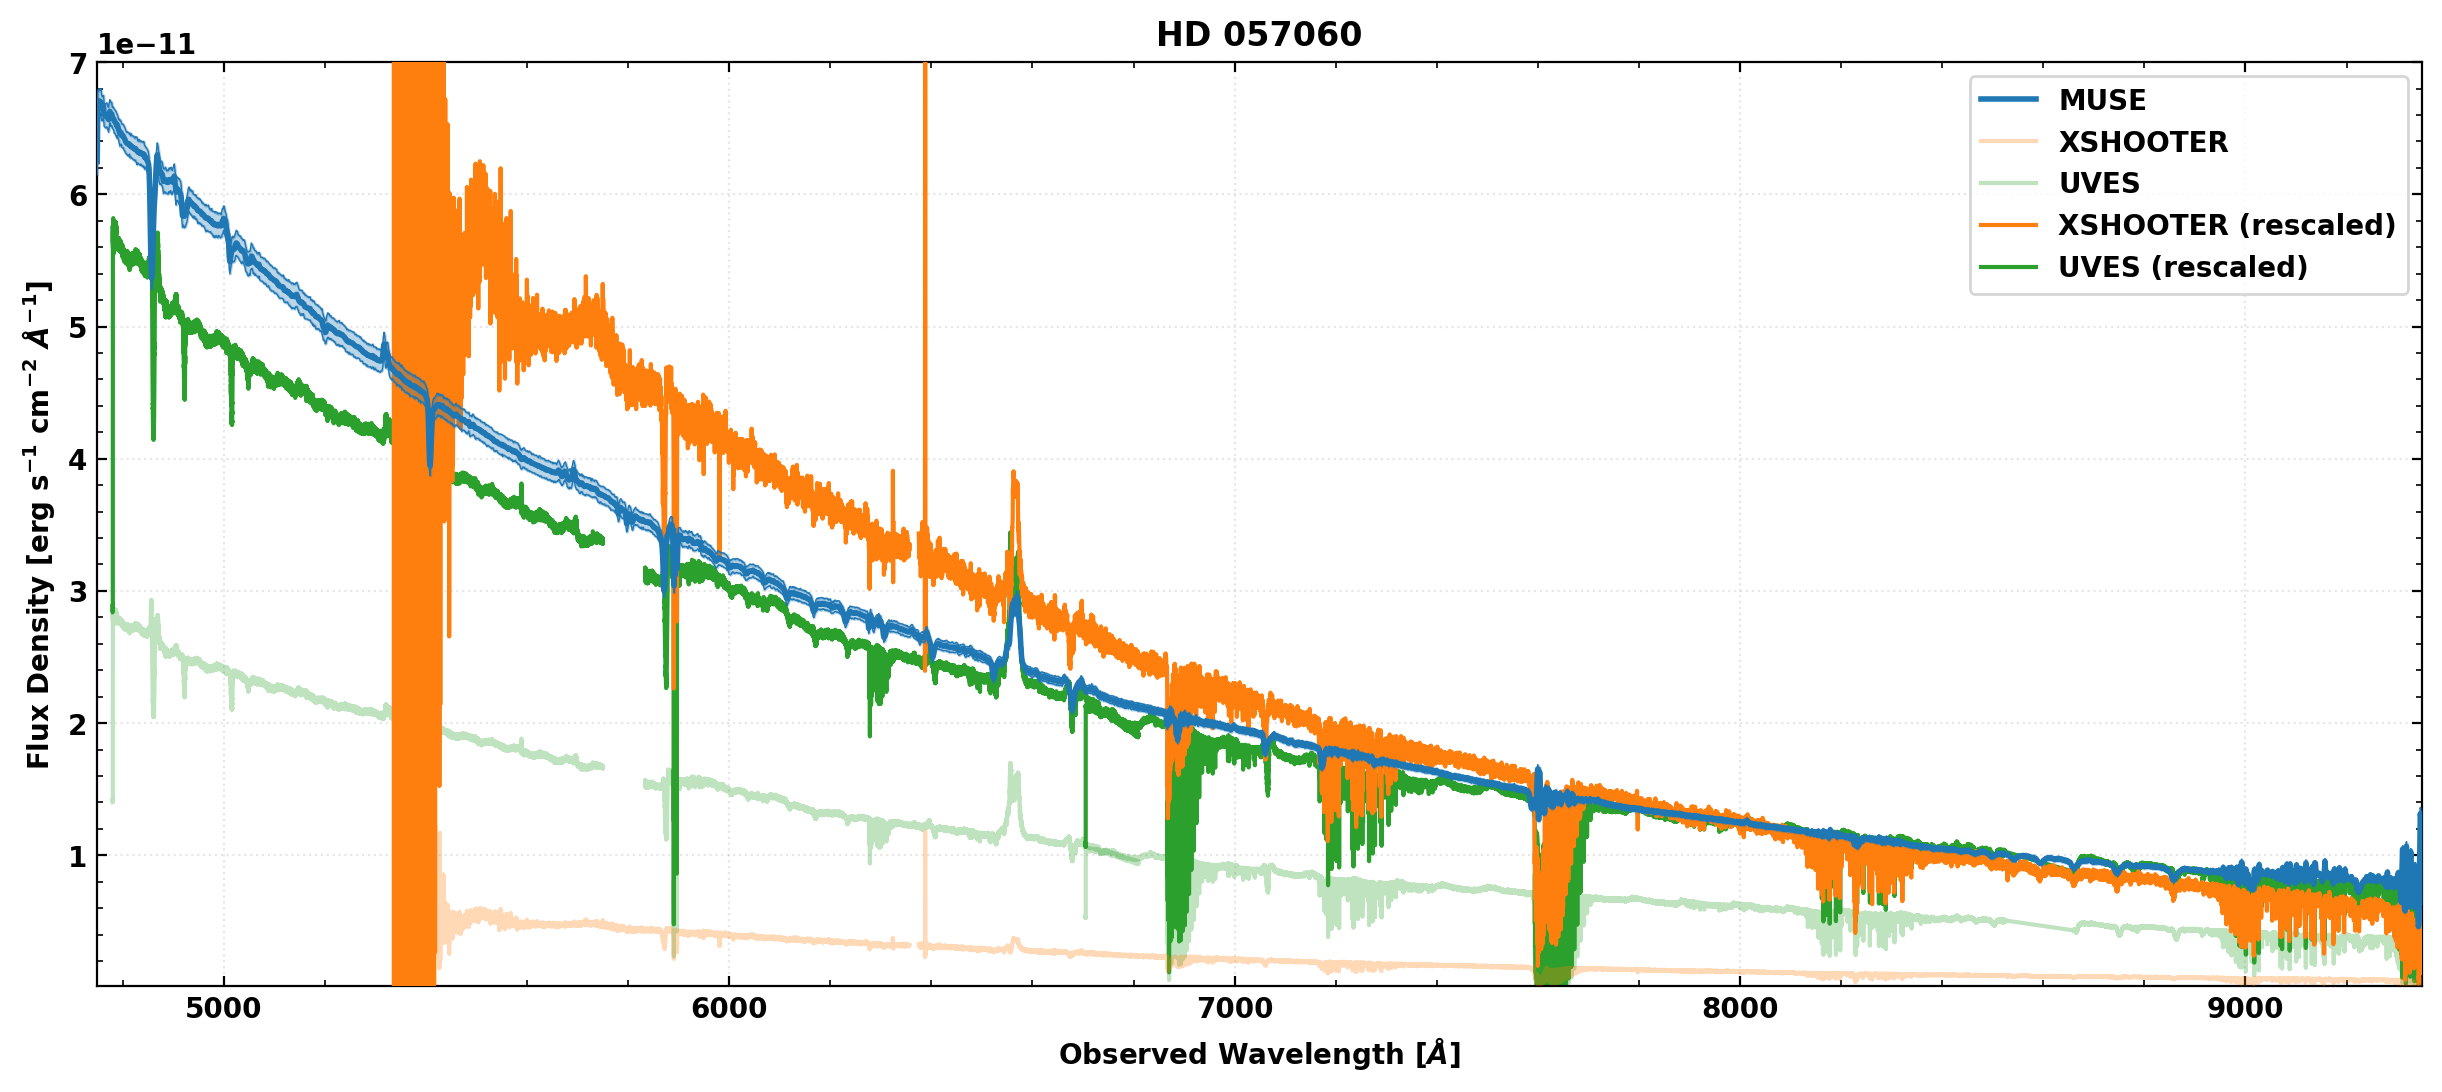

In [12]:
# Plot re-normalized spectra
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

ax.plot(spec_muse_wave, spec_muse_flux, c='C0', label='MUSE', zorder=4, lw=2)
ax.fill_between(spec_muse_wave, spec_muse_flux-spec_muse_fluxerr, spec_muse_flux+spec_muse_fluxerr, color='C0', alpha=0.3, zorder=4)
ax.plot(spec_muse_wave, spec_muse_flux-spec_muse_fluxerr, c='C0', zorder=4, lw=0.5)
ax.plot(spec_muse_wave, spec_muse_flux+spec_muse_fluxerr, c='C0', zorder=4, lw=0.5)

ax.plot(spec_xshooter1_wave, spec_xshooter1_flux, c='C1', alpha=0.3, label='XSHOOTER', zorder=3)
ax.plot(spec_uves1_wave, spec_uves1_flux, c='C2', alpha=0.3, label='UVES', zorder=2)
ax.plot(spec_uves2_wave, spec_uves2_flux, c='C2', alpha=0.3, zorder=2)

ax.plot(spec_xshooter1_wave, spec_xshooter1_flux_rescaled, label=r'XSHOOTER (rescaled)', c='C1', zorder=3)
ax.plot(spec_uves1_wave, spec_uves1_flux_rescaled, label=r'UVES (rescaled)', c='C2', zorder=2)
ax.plot(spec_uves2_wave, spec_uves2_flux_rescaled, c='C2', zorder=2)

ax.set_xlim(min(spec_muse_wave), max(spec_muse_wave))
ax.set_ylim(0.1e-12, 7e-11)
ax.set_xlabel(r'Observed Wavelength [$\AA$]')
ax.set_ylabel(r'Flux Density [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')
ax.set_title(r'HD 057060')

ax.legend(loc='upper right')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('figures/HD057060.png', format='png', bbox_inches='tight')

### <a id='HD 172230'> HD 172230 </a>


Cross calibrate wavelength solution to the highest resolution instrument and calculate radial velocities

In [27]:
hdu_muse =      fits.open('./data/ADP.2020-02-26T15:36:25.276.fits')
hdu_xshooter1 = fits.open('./data/ADP.2014-05-15T16:36:52.997.fits') # Older version of the dataset - Interal data product (IDP) - NODDING 
hdu_xshooter2 = fits.open('./data/ADP.2014-05-15T16:36:53.210.fits') # Older version of the dataset - Interal data product (IDP) - STARE
hdu_xshooter3 = fits.open('./data/ADP.2020-07-28T07:32:26.286.fits') # Newest version of the dataset - External data product (EDP)
hdu_uves =      fits.open('./data/ADP.2021-09-16T14:46:40.723.fits')

In [28]:
spec_muse_wave, spec_muse_flux, spec_muse_fluxerr = extract_spectrum(hdu_muse, 'MUSE', verbose=False)
spec_xshooter1_wave, spec_xshooter1_flux, spec_xshooter1_fluxerr = extract_spectrum(hdu_xshooter1, 'XSHOOTER', verbose=False, check_bary=True)
spec_xshooter2_wave, spec_xshooter2_flux, spec_xshooter2_fluxerr = extract_spectrum(hdu_xshooter2, 'XSHOOTER', verbose=False, check_bary=True)
spec_xshooter3_wave, spec_xshooter3_flux, spec_xshooter3_fluxerr = extract_spectrum(hdu_xshooter3, 'XSHOOTER', verbose=False, check_bary=True)
spec_uves_wave, spec_uves_flux, spec_uves_fluxerr = extract_spectrum(hdu_uves, 'UVES', verbose=False)

SPECSYS for MUSE: BARYCENT
SPECSYS for XSHOOTER: TOPOCENT
Barycentric correction for XSHOOTER: -6.51747757416766
Barycentric correction for XSHOOTER: -6.427029522805549 (using PyAstronomy)
SPECSYS for XSHOOTER: TOPOCENT
Barycentric correction for XSHOOTER: -6.51492525593263
Barycentric correction for XSHOOTER: -6.426722517284921 (using PyAstronomy)
SPECSYS for XSHOOTER: SOURCE
Barycentric correction for XSHOOTER: -6.42726916170844 (using PyAstronomy)
Source correction for XSHOOTER: -43.81
SPECSYS for UVES: TOPOCENT
Barycentric correction for UVES: 16.431138246234468 (using PyAstronomy)


In [29]:
def continuum_subtraction(wave, flux, wl_left_min=6423, wl_left_max=6428, wl_right_min=6685, wl_right_max=6690, poly_order=1):

    """ 
    Continuum subtraction using a polynomial fit 
    
    Parameters: 
    wavelength (numpy.ndarray): Array of wavelengths.
    flux (numpy.ndarray): Array of fluxes.
    wl_left_min (float): Minimum wavelength of the left continuum region.
    wl_left_max (float): Maximum wavelength of the left continuum region.
    wl_right_min (float): Minimum wavelength of the right continuum region.
    wl_right_max (float): Maximum wavelength of the right continuum region.
    poly_order (int): Order of the polynomial fit.

    Returns:
    flux_normalized (numpy.ndarray): Array of normalized fluxes.
    """

    poly_mask = (( (wave > wl_left_min) & (wave < wl_left_max) ) |
                    ( (wave > wl_right_min) & (wave < wl_right_max) ))
    poly_coeff = np.polyfit(np.log10(wave[poly_mask]), np.log10(flux[poly_mask]), deg=poly_order)
    flux_normalized = flux / 10.**(np.polyval(poly_coeff, np.log10(wave)))
    return flux_normalized

spec_muse_flux_normalized = continuum_subtraction(spec_muse_wave, spec_muse_flux)
spec_xshooter1_flux_normalized = continuum_subtraction(spec_xshooter1_wave, spec_xshooter1_flux)
spec_xshooter1_flux_normalized = continuum_subtraction(spec_xshooter1_wave, spec_xshooter1_flux)
spec_xshooter2_flux_normalized = continuum_subtraction(spec_xshooter2_wave, spec_xshooter2_flux)
spec_xshooter3_flux_normalized = continuum_subtraction(spec_xshooter3_wave, spec_xshooter3_flux)
spec_uves_flux_normalized = continuum_subtraction(spec_uves_wave, spec_uves_flux)

spec_muse_fluxerr_normalized = spec_muse_flux_normalized * (spec_muse_fluxerr / spec_muse_flux)

In [30]:
def calculate_velocity(wavelength, reference_wavelength=6562.793):
    """
    Calculate the velocity relative to a given reference wavelength.

    Parameters:
    wavelength (numpy.ndarray): Array of wavelengths.
    reference_wavelength (float): The reference wavelength to calculate the velocity. Default is 6562.793 (H-alpha line).

    Returns:
    numpy.ndarray: Array of velocities in km/s.
    """
    return (wavelength / reference_wavelength - 1) * const.c.to('km/s').value

spec_uves_vel = calculate_velocity(spec_uves_wave)
spec_xshooter1_vel = calculate_velocity(spec_xshooter1_wave)
spec_xshooter2_vel = calculate_velocity(spec_xshooter2_wave)
spec_xshooter3_vel = calculate_velocity(spec_xshooter3_wave)
spec_muse_vel = calculate_velocity(spec_muse_wave)

Check for differnces between the internal (IDP) and external (EDP) data products in the `XSHOOTER` spectra. 

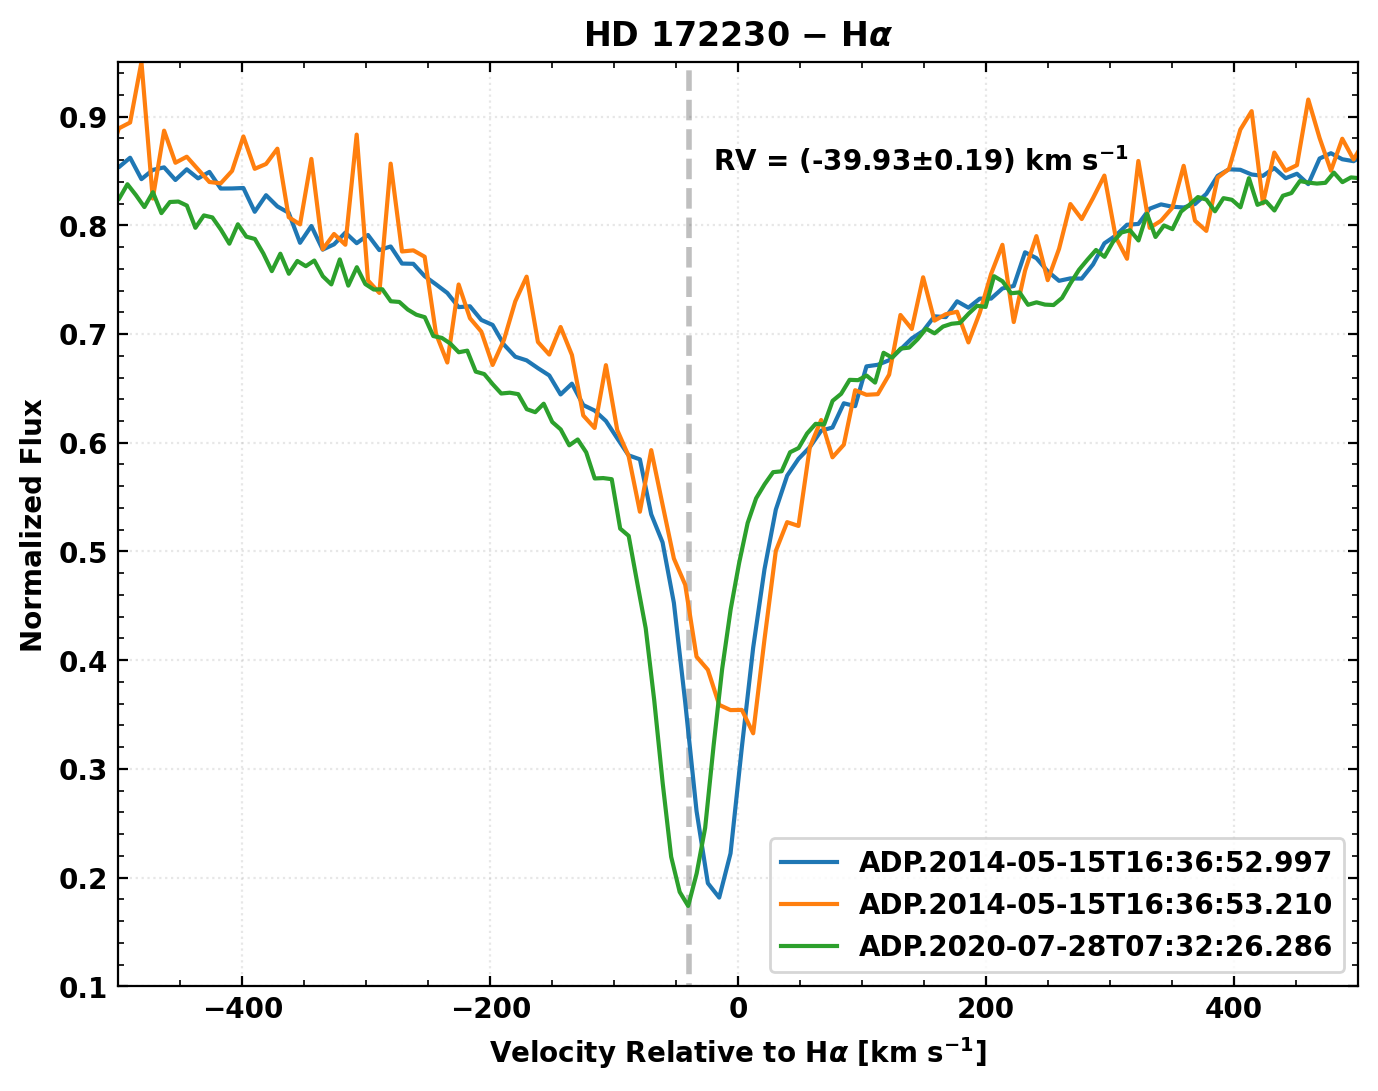

In [52]:
# Plot re-normalized spectra
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

radial_velocity = -39.93 # km/s
ax.plot([radial_velocity]*2, [-1,2], c='k', ls='--', lw=2, alpha=0.25)

ax.plot(spec_xshooter1_vel, spec_xshooter1_flux_normalized, c='C0', label='ADP.2014-05-15T16:36:52.997')
ax.plot(spec_xshooter2_vel, spec_xshooter2_flux_normalized, c='C1', label='ADP.2014-05-15T16:36:53.210')
ax.plot(spec_xshooter3_vel, spec_xshooter3_flux_normalized, c='C2', label='ADP.2020-07-28T07:32:26.286')

ax.set_xlim(-500., 500.)
ax.set_ylim(0.1, 0.95)
ax.text(radial_velocity+20, 0.85, r'RV = (-39.93$\pm$0.19) km s$^{-1}$', horizontalalignment='left')
ax.set_xlabel(r'Velocity Relative to H$\alpha$ [km s$^{-1}$]')
ax.set_ylabel(r'Normalized Flux')
ax.set_title(r'HD 172230 $-$ H$\alpha$')

ax.legend(loc='lower right')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('./figures/HD172230_6562_xshooteronly.png', format='png', bbox_inches='tight')

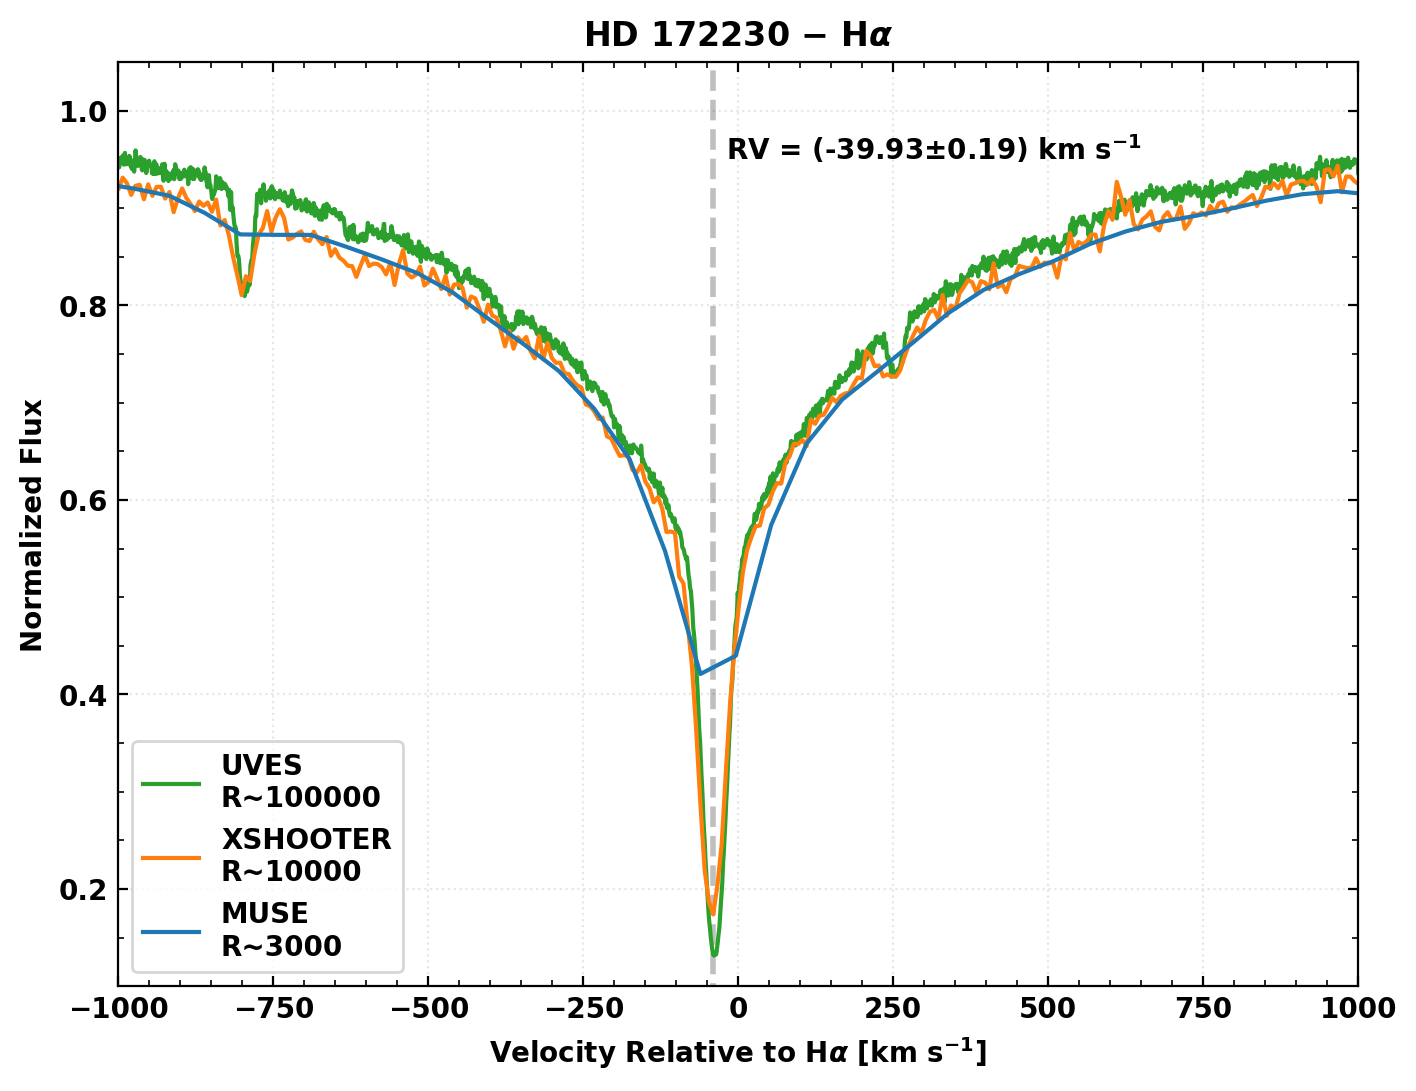

In [47]:
# Plot re-normalized spectra
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

radial_velocity = -39.93 # km/s
ax.plot([radial_velocity]*2, [-1,2], c='k', ls='--', lw=2, alpha=0.25)

ax.plot(spec_uves_vel, spec_uves_flux_normalized, label=r'UVES' + '\n' + 'R~100000', c='C2')
ax.plot(spec_xshooter3_vel, spec_xshooter3_flux_normalized, label=r'XSHOOTER' + '\n' + 'R~10000', c='C1')
ax.plot(spec_muse_vel, spec_muse_flux_normalized, label=r'MUSE' + '\n' + 'R~3000', c='C0')

ax.set_xlim(-1000., 1000.)
ax.set_ylim(0.1, 1.05)
ax.text(radial_velocity+20, 0.95, r'RV = (-39.93$\pm$0.19) km s$^{-1}$', horizontalalignment='left')
ax.set_xlabel(r'Velocity Relative to H$\alpha$ [km s$^{-1}$]')
ax.set_ylabel(r'Normalized Flux')
ax.set_title(r'HD 172230 $-$ H$\alpha$')

ax.legend(loc='lower left')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('./figures/HD172230_6562.png', format='png', bbox_inches='tight')

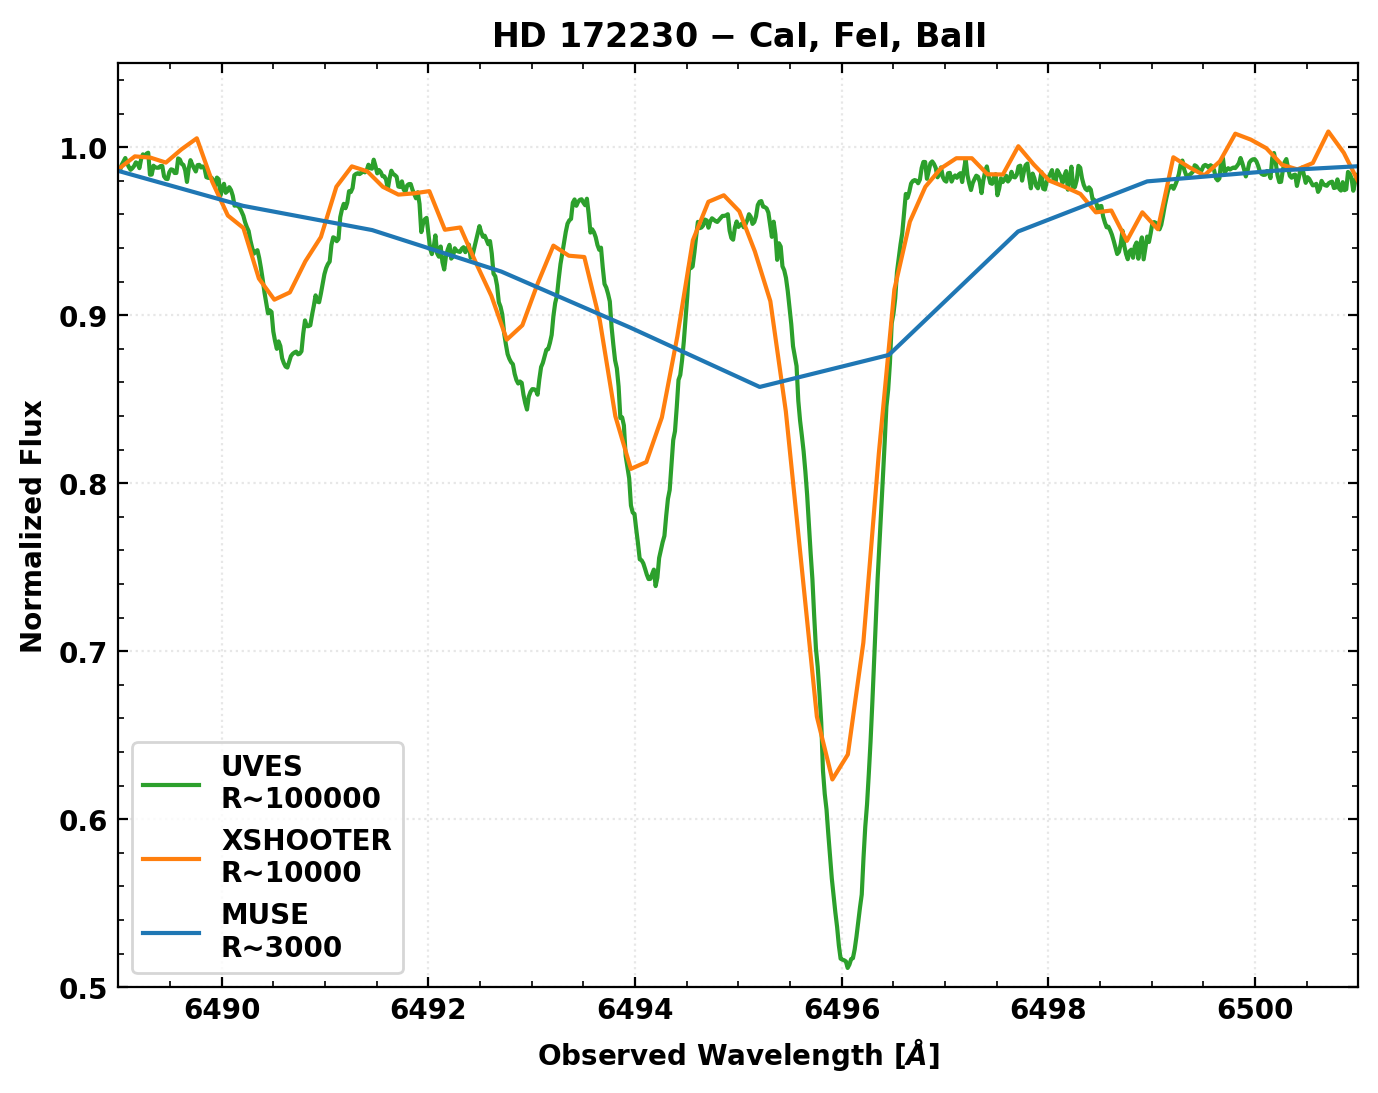

In [48]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(spec_uves_wave, spec_uves_flux_normalized, label=r'UVES' + '\n' + 'R~100000', c='C2')
ax.plot(spec_xshooter3_wave, spec_xshooter3_flux_normalized, label=r'XSHOOTER' + '\n' + 'R~10000', c='C1')
ax.plot(spec_muse_wave, spec_muse_flux_normalized, label=r'MUSE' + '\n' + 'R~3000', c='C0')

ax.set_xlim(6495.-6., 6495.+6.)
ax.set_ylim(0.5, 1.05)
ax.set_xlabel(r'Observed Wavelength [$\AA$]')
ax.set_ylabel(r'Normalized Flux')
ax.set_title(r'HD 172230 $-$ CaI, FeI, BaII')

ax.legend(loc='lower left')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('./figures/HD172230_6490.png', format='png', bbox_inches='tight')